# How to acquire data with Acoular
<!-- How to acquire data with Acoular
- tags: [data acquisition]
- authors: Adam Kujawski, Gert Herold
- comments: true-->

Acoular is a Python library that processes multichannel data (up to a few hundred channels) from acoustic measurements with a microphone array which is stored in an HDF5 file. This blog post explains how to acquire data with Acoular and save that data in an HDF5 file.

It is required that the current environment includes the `sounddevice` library, which ships with Acoular when the framework is installed with all dependencies, i.e.:

```console
pip install acoular['full']
```

Alternatively, `sounddevice` can be installed using conda

```console
conda install -c conda-forge python-sounddevice
```

or pip

```console
pip install sounddevice
```

First, we check what devices are available on the current machine:

In [1]:
import sounddevice as sd

sd.query_devices()

   0 HDA NVidia: U32R59x (hw:1,3), ALSA (0 in, 2 out)
   1 HDA NVidia: HDMI 1 (hw:1,7), ALSA (0 in, 8 out)
   2 HDA NVidia: HDMI 2 (hw:1,8), ALSA (0 in, 8 out)
   3 HDA NVidia: HDMI 3 (hw:1,9), ALSA (0 in, 8 out)
   4 nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0), ALSA (16 in, 0 out)
   5 sysdefault, ALSA (128 in, 128 out)
   6 front, ALSA (0 in, 2 out)
   7 surround40, ALSA (0 in, 2 out)
   8 surround51, ALSA (0 in, 2 out)
   9 surround71, ALSA (0 in, 2 out)
  10 hdmi, ALSA (0 in, 8 out)
* 11 default, ALSA (128 in, 128 out)
  12 dmix, ALSA (0 in, 2 out)

## Getting data from input channels

Acoular provides a means to deal with audio data streams via the `SoundDeviceSamplesGenerator` class.
It uses the _sounddevice_ library under the hood. Here, we instantiate this class and select the desired audio interface by setting its device index. Since we only want to acquire the data of a single channel, we set `numchannels=1`. The sample frequency of the audio interface equals to 44.1 kHz, which can be inferred from the object instance.

In [2]:
import acoular as ac
ac.config.global_caching = 'none'


dev = ac.SoundDeviceSamplesGenerator(
    device = 4,
    numchannels = 1,
)

print("Sampling frequency: ", dev.sample_freq)

freq = dev.sample_freq


Sampling frequency:  44100.0


Import some plotting functionality:

In [3]:
import matplotlib.pyplot as plt

Next, we want to acquire a signal with a length of two seconds. Therefore, the input stream is read block by block with a blocksize of 256 samples. We use the `return_result` function to retrieve all blocks in one go. 
When starting to stream data, the `SoundDeviceSamplesGenerator` object will print an output of the device properties.

In [4]:
recording_time = 2 # seconds 
dev.numsamples = int(recording_time * dev.sample_freq)

signal = ac.tools.return_result(dev, num=256)


{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0)', 'index': 4, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0


The Numpy array contains the time data on the first and the number of channels on the second axis. 

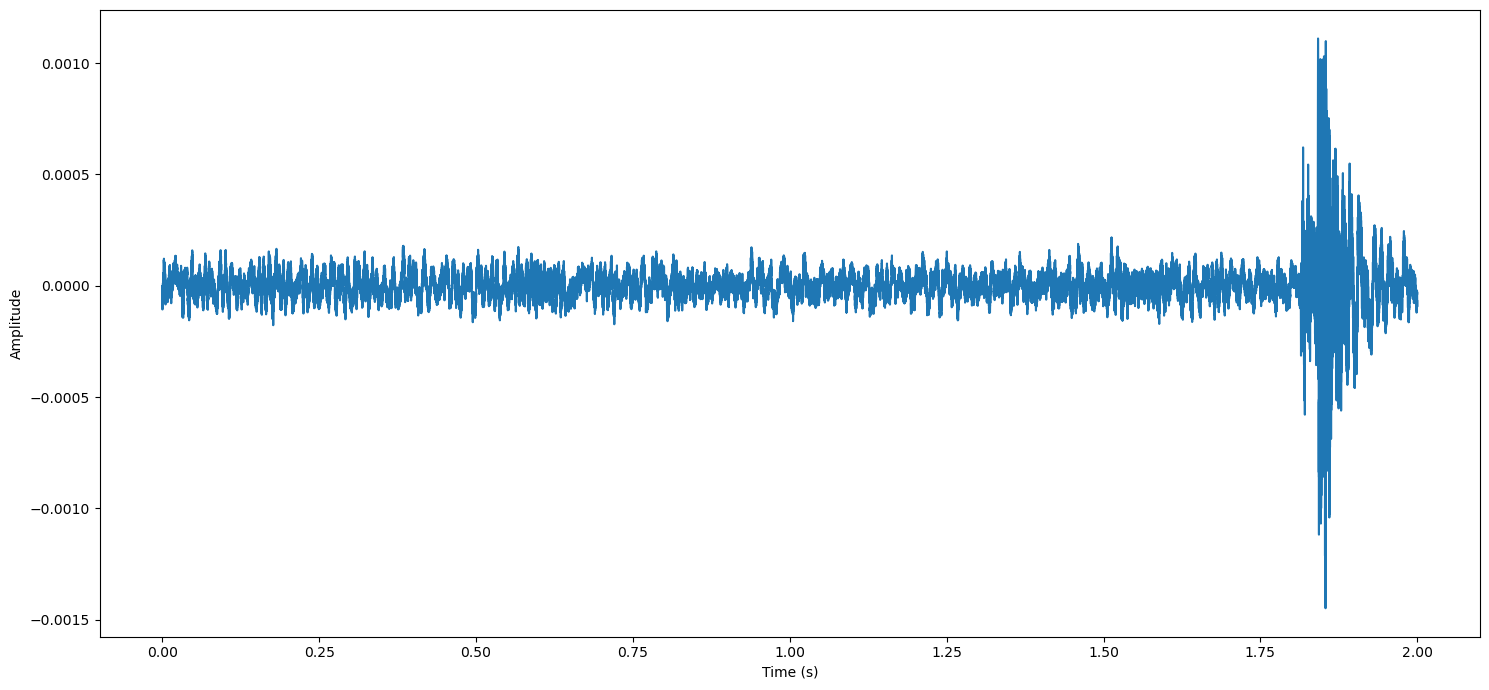

In [5]:
import numpy as np

t = np.arange(signal.shape[0]) / dev.sample_freq
plt.figure(figsize=(15,7))
plt.plot(t, signal[:,0])
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Writing measurement data to disk

Instead of or in addition to acquiring the time data, it is possible to add further processing steps by means of classes defined in Acoular's `tprocess.py` module. For example, one may use the `WriteH5` and the `WriteWAV` class to save the full stream to an HDF5 file and to write a particular channel to a WAV file for listening. 

In [6]:
hdf5 = ac.WriteH5(
    source = dev,
    name = 'sounddevice.h5',
)

wav = ac.WriteWAV(
    source = dev,
    name = 'sounddevice.wav',
    channels = [0],    
)

In the previous code snippet, we created two processing chains, which both can read the data from the audio interface `dev` of class (`SoundeDeviceSamplesGenerator`) and can either pass it on or save it on the hard disk.

Due to the lazy evaluation paradigm, nothing has been processed yet. 
Using the `WriteWAV` object name `wav` as example, we have two choices to start the acquisition and writing:

    (1) calling `wav.result(num=256)` to create a generator which yields the data block-wise (num can be set to different values)
    (2) calling `wav.save()` which runs the processing chain with a single function call and does not return the data

This time, we go with option (2)

In [7]:
wav.save()

{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0)', 'index': 4, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0
{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0)', 'index': 4, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0


This saves a wav file on the hard disk, which then can processed with any software capable of dealing with this format. 
For our purposes, we usually use the HDF5 format, so let's quickly export a file like that:

In [8]:
hdf5.save()

{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0)', 'index': 4, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0


## A multi-step processing chain

As usual, we can use the `TimeSamples` object to read the data back for further post-processing

1
88200
44100.0


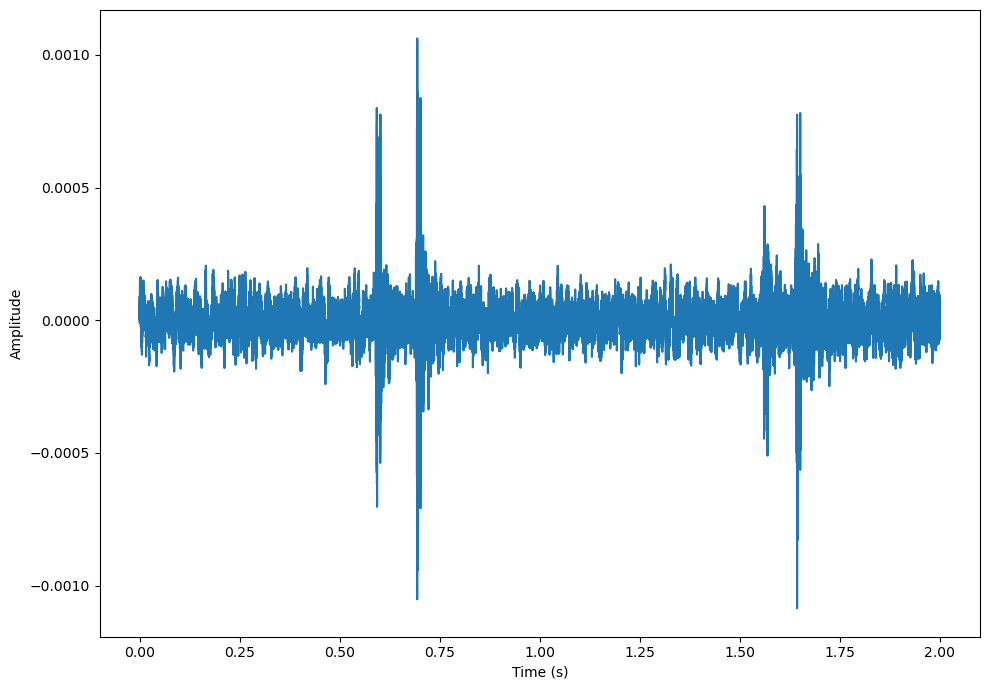

In [9]:
ts = ac.TimeSamples(name='sounddevice.h5')

print(ts.numchannels)
print(ts.numsamples)
print(ts.sample_freq)


signal = ac.tools.return_result(ts, num=256)
t = np.arange(signal.shape[0]) / dev.sample_freq
plt.figure(figsize=(10,7))
plt.plot(t, signal[:,0])
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

Beside simply saving the data we could add further processing steps, e.g. by adding a `OctaveFilterBank` for periodically displaying the third-octave spectra of the first channel. 

In [10]:
filt = ac.OctaveFilterBank(
    source = dev,
    fraction='Third octave',
    )
tp = ac.TimePower(
    source=filt,
)
ta = ac.TimeAverage(
    source=tp,
    naverage=4096,
)
data = next(ta.result(1))

{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0)', 'index': 4, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0


Next, we can plot the third-octave spectra by means of the `barspectrum` method available in `acoular.tools`.

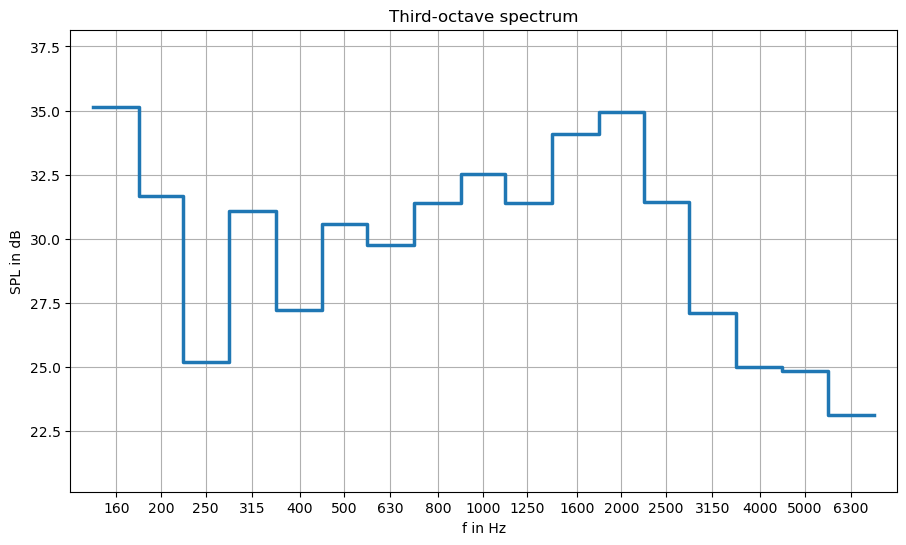

In [11]:

(f_borders, p, f_center) = ac.tools.barspectrum(
    data = data[0]/0.016**2, # pseudo calibration with 16mV/Pa
    fftfreqs = filt.bands, 
    num = 3, 
    bar=True)

Lp_max = ac.L_p(p).max()
Lp_min = ac.L_p(p).min()

# create figure with barspectra
plt.figure(figsize=(16/1.5,9/1.5))
plt.title('Third-octave spectrum')
plt.plot(f_borders, ac.L_p(p), linewidth=2.5)
plt.xlim(f_borders[0] * 2 ** (-1.0 / 6), f_borders[-1] * 2 ** (1.0 / 6))
plt.ylim(Lp_min-3, Lp_max+3)
plt.xscale('symlog')
label_freqs = [str(int(_)) for _ in f_center]  # create string labels
plt.xticks(f_center, label_freqs)
plt.xlabel('f in Hz')
plt.ylabel('SPL in dB')
plt.grid(True)
plt.show()

The above code delivers the third-octave spectrum from averaging the power of band-passed time data.

## Getting short time spectra 

A common way of getting a spectrum representation of data is to use an FFT.
This is easily doable via a different processing chain using an `FFTSpectra` object.
Just as an example, we only evaluate a very short time segment with a duration of only a fraction of a second next. 
We also leave out the intermediate step of saving a file and read the data directly from the device.

{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0)', 'index': 4, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0


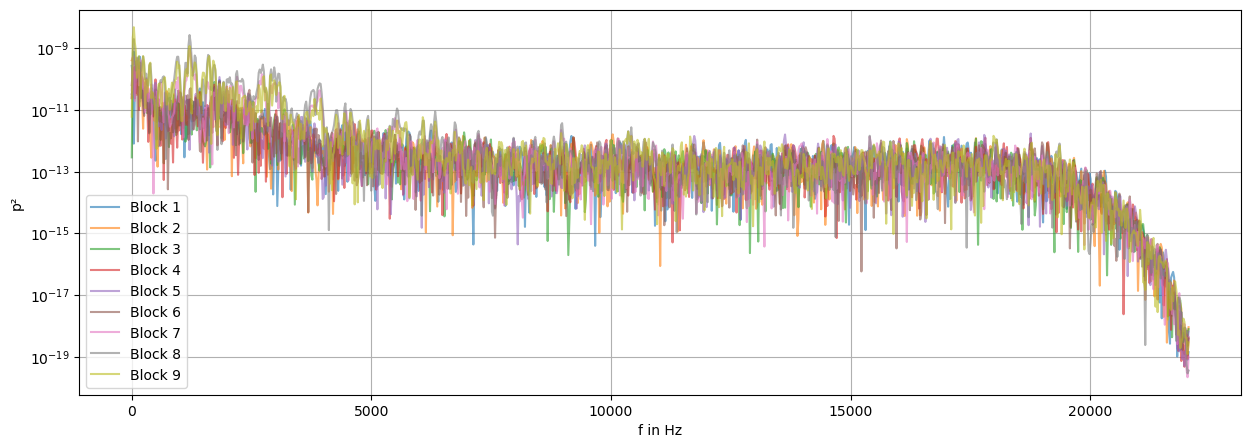

In [12]:
block = 2048

dev.numsamples =  block*3
spec = ac.FFTSpectra(
    source = dev, 
    block_size = block, 
    window='Hanning', 
    overlap='75%')

freqs = spec.fftfreq()
plt.figure(1,(15,5))
nblock=0
for p in spec.result():
    nblock+=1
    plt.plot(freqs, (p*p.conj()).real, alpha=0.6, label=f'Block {nblock:d}')

plt.yscale('log')
plt.xlabel('f in Hz')
plt.ylabel('p²')
plt.grid(True)
plt.legend()
plt.show()

## Multi-channel example

#### Set up input device parameters:

In [13]:
dev.device = 0 
dev.numchannels = 16

recording_time = 5 # seconds 
dev.numsamples = int(recording_time * dev.sample_freq)

#### Set up processing chain:

Exception occurred in traits notification handler for object: <acoular.microphones.MicGeom object at 0x74b1b6c0a6b0>, trait: basename, old value: None, new value: minidsp_uma16
Traceback (most recent call last):
  File "/home/rabea/micromamba/envs/ba_test/lib/python3.11/site-packages/traits/trait_notifiers.py", line 524, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/home/rabea/micromamba/envs/ba_test/lib/python3.11/site-packages/traits/trait_notifiers.py", line 486, in dispatch
    handler(*args)
  File "/home/rabea/micromamba/envs/ba_test/lib/python3.11/site-packages/acoular/microphones.py", line 115, in import_mpos
    doc = xml.dom.minidom.parse(self.from_file)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rabea/micromamba/envs/ba_test/lib/python3.11/xml/dom/minidom.py", line 1990, in parse
    return expatbuilder.parse(file)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rabea/micromamba/envs/ba_test/lib/python3.11/xml/dom/expatbuilder.py",

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

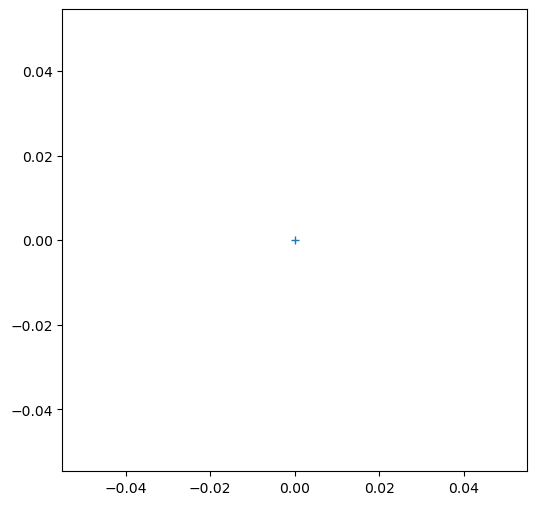

In [14]:
from os import path
from pathlib import Path
import acoular as ac
import numpy as np
import matplotlib.pyplot as plt



micgeom_path = Path(ac.__file__).parent / 'xml' / 'minidsp_uma16.xml'
m = ac.MicGeom(from_file = micgeom_path)


plt.figure(4,(6,6))
plt.plot(0,0,'+')
#plt.plot(m.mpos[0],m.mpos[1],c='gray')
for i in range(m.num_mics):
    plt.plot(m.mpos[0,i],m.mpos[1,i],'oC0')
    plt.text(m.mpos[0,i]+0.0025,m.mpos[1,i]+0.0025,str(i+1))

plt.axis('equal')

In [15]:
#%% focus grid
ar = 0.25
g = ac.RectGrid(
    x_min=-ar/2, x_max=+ar/2, 
    y_min=-ar/2, y_max=+ar/2, 
    z=0.5, 
    increment=0.01)

#%% environment
temperature = 18 #°C
c0 = (1.402 * 287.103 * (273.15 + temperature))**0.5
env = ac.Environment(c=c0)

#%% steering vector
sv = ac.SteeringVector(
    grid = g, 
    mics = m, 
    env = env,
    steer_type = 'true location',
)


#%% csm
f = ac.PowerSpectra(
    time_data = dev,
    window = 'Hanning', 
    overlap = '50%', 
    block_size = 512,
)

#%% beamformers

bfc = ac.BeamformerCleansc(freq_data = f, steer = sv, r_diag = False)
bfb = ac.BeamformerBase(freq_data = f, steer = sv, r_diag = False)

print(f'Speed of sound: {bfb.steer.env.c:.2f} m/s')

Speed of sound: 342.33 m/s


#### Start processing:

In [16]:
#%% start processing
bf = bfb
freq = 8000


mapn = bf.synthetic(freq, 3) # 1/3 octave band
# normalize result to maximum as 0 dB
mapn *=4e-10/mapn.max()

plt.figure(5,(8,8))

plt.imshow(ac.L_p(mapn.T) , vmax=0, vmin=-2, 
           interpolation='nearest', 
           extent=g.extend(), 
           origin='lower')
plt.colorbar()




#savefig('ex_fast.png', bbox_inches=0, dpi=400)
plt.show()

ValueError: 0 channels do not fit 0 mics